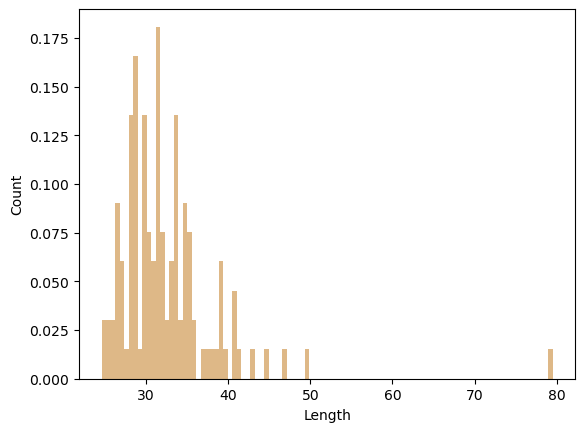

20.458168029785156 43.04212188720703


tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]      121 read,        0 written
tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]      121 read,        5 written
tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]        5 read,        5 written
tckedit: [WARNING] existing output files will be overwritten
tckedit: [done]      121 read,      117 written


In [43]:
import nibabel as nib
from dipy.io.streamline import load_tractogram, save_trk
from dipy.tracking.utils import length
import numpy as np
import subprocess
import os

tract_path = "../study/subjects/VNSLC_19/dMRI/tractography/right-thalamus-Insula.tck"
# remotion of outliers IQR rule
trk = nib.streamlines.load(tract_path).tractogram
bundle  = trk.streamlines

lengths = list(length(bundle))

import matplotlib.pyplot as plt

fig_hist, ax = plt.subplots(1)
ax.hist(lengths, color='burlywood', bins=100, density=True)
ax.set_xlabel('Length')
ax.set_ylabel('Count')
plt.show()

q1 = np.quantile(lengths, 0.25)
q3 = np.quantile(lengths, 0.75)
iqr = q3 - q1
upper = q3 + 1.5*iqr
lower = q1 - 1.5*iqr
print(lower, upper)

cmd = "tckedit -maxlength %f -force %s %s && tckedit -minlength %f -force %s %s && tckedit -force %s %s %s" % (lower, tract_path, "../lower.tck", upper, tract_path, "../upper.tck", "../lower.tck", "../upper.tck", "../removed.tck")
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
process.wait()
os.remove("../lower.tck"); os.remove("../upper.tck")

tract = load_tractogram("../removed.tck", "../study/subjects/VNSLC_19/dMRI/preproc/VNSLC_19_dmri_preproc.nii.gz")
save_trk(tract, "../removed.trk")

cmd = "tckedit -minlength %f -maxlength %f -force %s %s" % (lower, upper,tract_path, "../prova.tck")
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
process.wait()

tract = load_tractogram("../prova.tck", "../study/subjects/VNSLC_19/dMRI/preproc/VNSLC_19_dmri_preproc.nii.gz")
save_trk(tract, "../prova.trk")

laplace -------------
---------------------
MEAN---------------
numpy:	 -0.009666452777005544
scipy:	 -0.009666452777005544
pandas:	 -0.009666452777005544
mine:	 -0.009666452777005532
numpyW:	 -0.030043536144822372
mine_W:	 -0.03004353614482234
STD ---------------
numpy:	 1.4059891621102578
scipy:	 1.4066926843770051
pandas:	 1.4066926843770051
mine:	 1.4066926843770053
mineW:	 1.4316074656528286
alt_W:	 1.4303371927740338
SKEW ---------------
scipy:	 0.1541822276952529
pandas:	 0.15418222769525286
mine:	 0.15586449869415672
KURT ---------------
scipy:	 2.6040355871300322
pandas:	 2.6040355871300327
pandas:	 2.6040355871300327
mine:	 2.589218698472485

norm -------------
---------------------
MEAN---------------
numpy:	 0.022066401004866797
scipy:	 0.022066401004866797
pandas:	 0.022066401004866797
mine:	 0.022066401004866804
numpyW:	 -0.018188787982454702
mine_W:	 -0.018188787982454695
STD ---------------
numpy:	 1.071373944800858
scipy:	 1.0719100338735852
pandas:	 1.0719100338735852

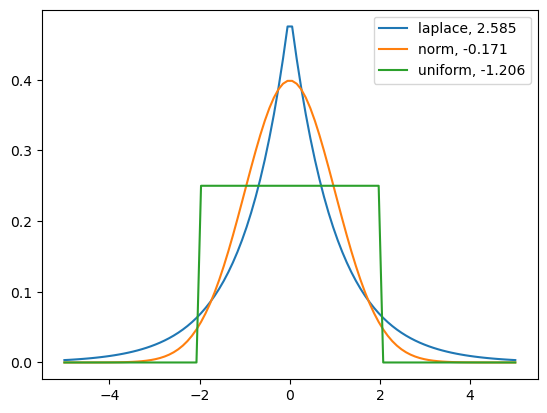

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from metrics import w_kurt, w_mean, w_var, w_skew, w_mean_alt, w_std_alt

x = np.linspace(-5, 5, 100)
ax = plt.subplot()
distnames = ['laplace', 'norm', 'uniform']

for distname in distnames:
    if distname == 'uniform':
        dist = getattr(stats, distname)(loc=-2, scale=4)
    else:
        dist = getattr(stats, distname)
    data = dist.rvs(size=1000)
    kur = stats.kurtosis(data, fisher=True)
    y = dist.pdf(x)
    ax.plot(x, y, label="{}, {}".format(distname, round(kur, 3)))
    ax.legend()

    weights = np.random.rand(data.size)

    print(distname, "-------------")
    print("---------------------")

    print("MEAN---------------")
    print("numpy:\t", np.mean(data))
    print("scipy:\t", stats.tmean(data))
    print("pandas:\t", pd.DataFrame(data).mean(axis=0)[0])
    print("mine:\t", w_mean(data, np.ones(data.size)))
    #print("alt:\t", w_mean_alt(data, np.ones(data.size)))
    print("numpyW:\t", np.average(data, weights=weights))
    print("mine_W:\t", w_mean(data, weights))
    #print("alt_w:\t", w_mean_alt(data, weights))

    print ("STD ---------------")
    print("numpy:\t", np.std(data))
    print("scipy:\t", stats.tstd(data))
    print("pandas:\t", pd.DataFrame(data).std(axis=0)[0])
    print("mine:\t", np.sqrt(w_var(data, np.ones(data.size))))
    print("mineW:\t", np.sqrt(w_var(data, weights)))
    print("alt_W:\t", w_std_alt(data, weights))

    print ("SKEW ---------------")
    print("scipy:\t", stats.skew(data,bias=False))
    print("pandas:\t", pd.DataFrame(data).skew(axis=0)[0])
    print("mine:\t", w_skew(data, np.ones(data.size)))

    print("KURT ---------------")
    print("scipy:\t", stats.kurtosis(data, fisher=True, bias=False))
    print("pandas:\t", pd.DataFrame(data).kurtosis(axis=0)[0])
    print("pandas:\t", pd.DataFrame(data).kurt(axis=0)[0])
    print("mine:\t", w_kurt(data, np.ones(data.size)))

    print()


Errore sul metodo alternativo per calcolare la media pesata

In [2]:
from metrics import vcol, vrow

d = np.array([3,3,3,4,3,3,3,3])
a = np.array([0.07285,0.07285,0.07285,0.49005,0.07285,0.07285,0.07285,0.07285])

d = d.ravel()
a = a.ravel()
a = a/np.sum(a)

b = np.random.random(10)
b = vcol(b)
b = np.tile(b, (1, a.size))

for i, v in enumerate(b):
    b[i:i+1] = (v <= a.cumsum()).argmax()
b = np.array(b, dtype=int)

print((b==3).sum(), "over", b.size,"ratio", (b==3).sum()/b.size, "real", a[3], "error", np.abs((b==3).sum()/b.size - a[3]) )
print(b)

np.mean(d[b])

[0.89228343 0.74817969 0.43690395 0.74107815 0.87380195 0.18530712
 0.6055885  0.24010515 0.23000567 0.93268028]
4 over 10 ratio 0.4 real 0.49005000000000004 error 0.09005000000000002
[6 4 3 4 6 2 3 3 3 7]


3.4

In [16]:
b = np.random.random(10)
b = vcol(b)
rb = np.tile(b, (1, 8))

In [12]:
a = np.array([0.07285,0.07285,0.07285,0.49005,0.07285,0.07285,0.07285,0.07285])
a = a.cumsum()
a = vrow(a)
ra = np.tile(a, (10, 1))

In [21]:
rb <= ra

array([[False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False, False, False, False,  True],
       [False, False, False,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True]])

In [20]:
(rb <= ra).argmax(axis=1) 

array([3, 7, 3, 2, 3, 0, 3, 3, 3, 3])